# Algoritmos Evolutivos para Otimização de Hiperparâmetros de MLP em Python

Este notebook apresenta uma implementação prática de como Algoritmos Evolutivos (AEs) podem ser usados para otimizar os hiperparâmetros de um Multi-Layer Perceptron (MLP) utilizando as bibliotecas **DEAP** e **scikit-learn**. Exploramos os fundamentos teóricos, a construção do AE, o treinamento e validação do MLP, além da análise das métricas de desempenho e curvas de loss.

## 1. Fundamentos Teóricos

### 1.1 Algoritmos Evolutivos (AEs)

Algoritmos Evolutivos são metaheurísticas inspiradas nos princípios da seleção natural e evolução biológica. Eles operam sobre uma população de soluções candidatas (indivíduos) que evoluem ao longo de gerações através de operações de:

* **Seleção**: Escolha dos indivíduos mais aptos para reprodução.
* **Cruzamento (Crossover)**: Combinação de dois indivíduos para gerar descendentes.
* **Mutação**: Introdução de variação aleatória nos indivíduos.

O processo se repete até que um critério de parada seja alcançado, como um número máximo de gerações ou desempenho satisfatório.

### 1.2 Multi-Layer Perceptron (MLP)

O MLP é uma rede neural artificial do tipo feedforward, composta por:

* Camada de entrada
* Uma ou mais camadas ocultas
* Camada de saída

Cada neurônio realiza uma combinação linear dos inputs seguida de uma função de ativação. O treinamento é realizado via retropropagação (backpropagation) com otimizadores como SGD, Adam, etc.

O MLP é poderoso para aprender padrões não lineares, sendo aplicado em classificação, regressão e muito mais.

### 1.3 Otimização de Hiperparâmetros com AEs

Hiperparâmetros são configurações que afetam o treinamento da rede, mas não são aprendidos automaticamente. Exemplos:

* `learning_rate_init`: taxa de aprendizado
* `max_iter`: número de épocas
* `hidden_layer_sizes`: arquitetura da rede
* `activation`: função de ativação
* `solver`: otimizador

Métodos tradicionais como grid search são lentos em espaços grandes. AEs são mais eficientes, pois exploram o espaço de busca de forma estocástica e guiada pela função de aptidão (ex: F1-score).

Cada indivíduo no AE representa um conjunto de hiperparâmetros, e sua avaliação envolve treinar um MLP com esses valores e medir seu desempenho.

### 1.4 Métricas de Avaliação

Para tarefas de classificação, especialmente com dados desbalanceados, utilizamos:

* **Precisão (Precision)**:
  $\text{Precision} = \frac{TP}{TP + FP}$

* **Recall (Sensibilidade)**:
  $\text{Recall} = \frac{TP}{TP + FN}$

* **F1-score**:
  $F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

Onde:

* TP: verdadeiro positivo
* TN: verdadeiro negativo
* FP: falso positivo
* FN: falso negativo

Essas métricas dão uma visão mais equilibrada do desempenho do modelo.

### 1.5 Curvas de Loss

Durante o treinamento do MLP, monitoramos:

* **Loss de treinamento**: erro sobre os dados usados para ajuste.
* **Loss de validação**: erro sobre dados não vistos (para verificar generalização).

Análises comuns:

* **Overfitting**: training loss diminui, validation loss sobe.
* **Underfitting**: ambas permanecem altas.
* **Boa convergência**: ambas diminuem e estabilizam.

A visualização dessas curvas é essencial para entender o comportamento da rede durante o ajuste dos hiperparâmetros.

---

Na próxima seção (em código Python), veremos como implementar isso na prática usando **DEAP** + **sklearn**, com indivíduos representando combinações de hiperparâmetros e função de fitness baseada no F1-score de validação.

##2. Preparação do Ambiente e Dados
2.1 Instalação de Bibliotecas
Primeiro, vamos garantir que temos as bibliotecas necessárias instaladas.

In [1]:
!pip install deap scikit-learn matplotlib

Collecting deap
  Downloading deap-1.4.3-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Requirement already satisfied: scikit-learn in /usr/local/lib/python3.11/dist-packages (1.6.1)
Requirement already satisfied: matplotlib in /usr/local/lib/python3.11/dist-packages (3.10.0)
Requirement already satisfied: numpy in /usr/local/lib/python3.11/dist-packages (from deap) (2.0.2)
Requirement already satisfied: scipy>=1.6.0 in /usr/local/lib/python3.11/dist-packages (from scikit-learn) (1.15.3)
Requirement already satisfied: joblib>=1.2.0 in /usr/local/lib/python3.11/dist-packages (from scikit-learn) (1.5.1)
Requirement already satisfied: threadpoolctl>=3.1.0 in /usr/local/lib/python3.11/dist-packages (from scikit-learn) (3.6.0)
Requirement already satisfied: contourpy>=1.0.1 in /usr/local/lib/python3.11/dist-packages (from matplotlib) (1.3.2)
Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.11/dist-packages (from matplotlib) (0.12.1)
Requirement already satisfied: fonttools>=4.22.0 in /usr/local/lib/python3.11/dist-packages (from matplotlib) (4.58.4)
Requirement already satisfied: kiwisolver>=1.3.1 in /usr/local/lib/python3.11/dist-packages (from matplotlib) (1.4.8)
Requirement already satisfied: packaging>=20.0 in /usr/local/lib/python3.11/dist-packages (from matplotlib) (24.2)
Requirement already satisfied: pillow>=8 in /usr/local/lib/python3.11/dist-packages (from matplotlib) (11.2.1)
Requirement already satisfied: pyparsing>=2.3.1 in /usr/local/lib/python3.11/dist-packages (from matplotlib) (3.2.3)
Requirement already satisfied: python-dateutil>=2.7 in /usr/local/lib/python3.11/dist-packages (from matplotlib) (2.9.0.post0)
Requirement already satisfied: six>=1.5 in /usr/local/lib/python3.11/dist-packages (from python-dateutil>=2.7->matplotlib) (1.17.0)
Downloading deap-1.4.3-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (135 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 7.0 MB/s eta 0:00:00
Installing collected packages: deap
Successfully installed deap-1.4.3

SyntaxError: invalid character '━' (U+2501) (ipython-input-1-1959199605.py, line 21)

##2.2 Geração de Dados Sintéticos
Para demonstrar, geraremos um conjunto de dados sintético para um problema de classificação binária usando scikit-learn.

In [ ]:
import numpy as np  # Importa a biblioteca NumPy para operações numéricas
from sklearn.datasets import make_classification  # Função para gerar dados sintéticos de classificação
from sklearn.model_selection import train_test_split  # Função para dividir os dados em conjuntos de treino/validação/teste
from sklearn.neural_network import MLPClassifier  # Importa o classificador de rede neural MLP do scikit-learn
from sklearn.metrics import f1_score, precision_score, recall_score  # Importa métricas de avaliação
import matplotlib.pyplot as plt  # Importa biblioteca para plotagem de gráficos
from deap import base, creator, tools, algorithms  # Importa módulos do DEAP para algoritmos evolutivos
import random  # Importa o módulo random para geração de números aleatórios
import warnings  # Importa o módulo warnings para manipulação de avisos

# Suprimir avisos de convergência do MLPClassifier para o propósito de otimização
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignora avisos do tipo FutureWarning
warnings.filterwarnings("ignore", category=UserWarning)  # Ignora avisos do tipo UserWarning

# Geração de dados sintéticos
X, y = make_classification(
    n_samples=1000,         # Número de amostras (linhas)
    n_features=20,          # Número total de atributos (colunas)
    n_informative=10,       # Número de atributos informativos
    n_redundant=5,          # Número de atributos redundantes
    n_classes=2,            # Número de classes (binário)
    random_state=42         # Semente para reprodutibilidade
)

# Divisão em conjuntos de treinamento, validação e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)  # Separa 20% dos dados para teste

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  # Separa 25% do restante para validação (equivalente a 20% do total)

print(f"Tamanho do conjunto de treinamento: {X_train.shape[0]}")  # Exibe o tamanho do conjunto de treino
print(f"Tamanho do conjunto de validação: {X_val.shape[0]}")      # Exibe o tamanho do conjunto de validação
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")         # Exibe o tamanho do conjunto de teste



* Tamanho do conjunto de treinamento: 600
* Tamanho do conjunto de validação: 200
* Tamanho do conjunto de teste: 200

# 3. Implementação do Algoritmo Evolutivo
Vamos configurar o framework DEAP para otimizar os hiperparâmetros do MLPClassifier.

## 3.1 Definição da Função de Aptidão (Fitness Function)
A função de aptidão é o coração do algoritmo evolutivo. Ela recebe um conjunto de hiperparâmetros, treina um MLP com esses parâmetros e retorna uma métrica de desempenho (neste caso, o F1-score) no conjunto de validação.

In [2]:
from sklearn.datasets import load_iris  # Importa a função para carregar o dataset Iris
from sklearn.model_selection import train_test_split  # Importa função para dividir os dados em treino e validação
from sklearn.neural_network import MLPClassifier  # Importa o classificador MLP (rede neural) do scikit-learn
from sklearn.metrics import f1_score  # Importa a métrica F1 para avaliação do modelo
import numpy as np  # Importa a biblioteca NumPy para operações numéricas

# Carrega o dataset
iris = load_iris()  # Carrega o dataset Iris
X, y = iris.data, iris.target  # Separa os dados de entrada (X) e os rótulos (y)

# Divide os dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)  # Divide os dados em 70% treino e 30% validação

# Sua função de avaliação
def evaluate_mlp(individual):  # Define a função para avaliar um indivíduo (conjunto de hiperparâmetros)
    learning_rates = [0.0001, 0.001, 0.01, 0.1]  # Lista de taxas de aprendizado possíveis
    hidden_layer_sizes_options = [(50,), (100,), (50, 50), (100, 50)]  # Opções de tamanhos de camadas ocultas
    activations = ['logistic', 'tanh', 'relu']  # Funções de ativação possíveis
    solvers = ['adam', 'sgd']  # Solvers possíveis para o otimizador

    try:  # Tenta executar o bloco de código abaixo
        lr = learning_rates[individual[0]]  # Seleciona a taxa de aprendizado baseada no índice do indivíduo
        hidden_layers = hidden_layer_sizes_options[individual[1]]  # Seleciona o tamanho da camada oculta
        activation_func = activations[individual[2]]  # Seleciona a função de ativação
        solver_type = solvers[individual[3]]  # Seleciona o solver
        max_iterations = int(individual[4])  # Define o número máximo de iterações

        mlp = MLPClassifier(  # Cria o classificador MLP com os hiperparâmetros escolhidos
            hidden_layer_sizes=hidden_layers,  # Define as camadas ocultas
            activation=activation_func,  # Define a função de ativação
            solver=solver_type,  # Define o solver
            alpha=1e-5,  # Define o parâmetro de regularização
            batch_size='auto',  # Usa o batch_size padrão
            learning_rate_init=lr,  # Define a taxa de aprendizado inicial
            max_iter=max_iterations,  # Define o número máximo de iterações
            random_state=42,  # Semente para reprodutibilidade
            early_stopping=False,  # Não utiliza parada antecipada
            n_iter_no_change=10  # Número de iterações sem melhoria para parar (não usado pois early_stopping=False)
        )

        mlp.fit(X_train, y_train)  # Treina o modelo com os dados de treino
        y_pred = mlp.predict(X_val)  # Faz previsões nos dados de validação
        f1 = f1_score(y_val, y_pred, average='macro')  # Calcula o F1-score médio entre as classes

        return f1,  # Retorna o F1-score como uma tupla
    except Exception as e:  # Caso ocorra algum erro durante o processo
        print(f"Erro com indivíduo {individual}: {e}")  # Imprime o erro e o indivíduo problemático
        return 0.0,  # Retorna 0.0 como F1-score em

##3.2 Configuração do DEAP
Agora vamos configurar o DEAP para o nosso problema de otimização.

In [3]:
# CONFIGURAÇÃO DO DEAP
# =======================
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Cria classe de fitness para maximização
creator.create("Individual", list, fitness=creator.FitnessMax)  # Cria classe de indivíduo

toolbox = base.Toolbox()  # Cria a toolbox do DEAP
toolbox.register("attr_lr", random.randint, 0, 3)  # Gera índice para taxa de aprendizado
toolbox.register("attr_hidden_layers", random.randint, 0, 3)  # Gera índice para camadas ocultas
toolbox.register("attr_activation", random.randint, 0, 2)  # Gera índice para função de ativação
toolbox.register("attr_solver", random.randint, 0, 1)  # Gera índice para solver
toolbox.register("attr_max_iter", random.randint, 50, 500)  # Gera número de épocas

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_lr, toolbox.attr_hidden_layers,
                  toolbox.attr_activation, toolbox.attr_solver,
                  toolbox.attr_max_iter), n=1)  # Inicializa indivíduo

toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Inicializa população
toolbox.register("evaluate", evaluate_mlp)  # Registra função de avaliação
toolbox.register("mate", tools.cxTwoPoint)  # Registra operador de cruzamento
toolbox.register("mutate", tools.mutUniformInt,
                 low=[0, 0, 0, 0, 50], up=[3, 3, 2, 1, 500], indpb=0.1)  # Registra operador de mutação
toolbox.register("select", tools.selTournament, tournsize=3)  # Registra operador de seleção

NameError: name 'creator' is not defined

#3.3 Execução do Algoritmo Genético
Vamos executar o algoritmo genético e registrar as estatísticas do processo evolutivo.

In [ ]:
import numpy as np  # Importa a biblioteca NumPy para operações numéricas
import matplotlib.pyplot as plt  # Importa o matplotlib para plotar gráficos
from sklearn.datasets import make_classification  # Função para gerar dados sintéticos de classificação
from sklearn.model_selection import train_test_split  # Função para dividir os dados em conjuntos
from sklearn.neural_network import MLPClassifier  # Importa o classificador de rede neural MLP
from sklearn.metrics import f1_score, precision_score, recall_score  # Importa métricas de avaliação
from deap import base, creator, tools, algorithms  # Importa módulos do DEAP para algoritmos evolutivos
import random  # Importa o módulo random para geração de números aleatórios
import warnings  # Importa o módulo warnings para manipulação de avisos

warnings.filterwarnings("ignore", category=FutureWarning)  # Ignora avisos do tipo FutureWarning
warnings.filterwarnings("ignore", category=UserWarning)  # Ignora avisos do tipo UserWarning

# =======================
# DADOS SINTÉTICOS
# =======================
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5,
                           n_classes=2, random_state=42)  # Gera um conjunto de dados sintéticos

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)  # Divide em treino+validação e teste
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)  # Divide treino+validação em treino e validação

# =======================
# FUNÇÃO DE AVALIAÇÃO
# =======================
def evaluate_mlp(individual):  # Função para avaliar um indivíduo (conjunto de hiperparâmetros)
    learning_rates = [0.0001, 0.001, 0.01, 0.1]  # Lista de taxas de aprendizado possíveis
    hidden_layer_sizes_options = [(50,), (100,), (50, 50), (100, 50)]  # Opções de arquitetura de camadas ocultas
    activations = ['logistic', 'tanh', 'relu']  # Funções de ativação possíveis
    solvers = ['adam', 'sgd']  # Otimizadores possíveis

    try:
        lr = learning_rates[individual[0]]  # Seleciona a taxa de aprendizado pelo índice do indivíduo
        hidden_layers = hidden_layer_sizes_options[individual[1]]  # Seleciona arquitetura de camadas ocultas
        activation_func = activations[individual[2]]  # Seleciona função de ativação
        solver_type = solvers[individual[3]]  # Seleciona otimizador
        max_iterations = int(individual[4])  # Número de épocas (iterações)

        mlp = MLPClassifier(
            hidden_layer_sizes=hidden_layers,  # Define as camadas ocultas
            activation=activation_func,        # Define a função de ativação
            solver=solver_type,                # Define o otimizador
            alpha=1e-5,                        # Regularização L2 padrão
            batch_size='auto',                 # Tamanho do batch automático
            learning_rate_init=lr,             # Taxa de aprendizado inicial
            max_iter=max_iterations,           # Número máximo de iterações
            random_state=42,                   # Semente para reprodutibilidade
            early_stopping=False               # Não usar parada antecipada
        )

        mlp.fit(X_train, y_train)  # Treina o modelo MLP com os dados de treino
        y_pred = mlp.predict(X_val)  # Faz predições no conjunto de validação
        f1 = f1_score(y_val, y_pred)  # Calcula o F1-score das predições
        return f1,  # Retorna o F1-score como tupla (DEAP espera tupla)
    except Exception as e:
        print(f"Erro com indivíduo {individual}: {e}")  # Exibe erro ocorrido
        return 0.0,  # Retorna 0.0 para aptidão muito baixa

# =======================
# CONFIGURAÇÃO DO DEAP
# =======================
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Cria classe de fitness para maximização
creator.create("Individual", list, fitness=creator.FitnessMax)  # Cria classe de indivíduo

toolbox = base.Toolbox()  # Cria a toolbox do DEAP
toolbox.register("attr_lr", random.randint, 0, 3)  # Gera índice para taxa de aprendizado
toolbox.register("attr_hidden_layers", random.randint, 0, 3)  # Gera índice para camadas ocultas
toolbox.register("attr_activation", random.randint, 0, 2)  # Gera índice para função de ativação
toolbox.register("attr_solver", random.randint, 0, 1)  # Gera índice para solver
toolbox.register("attr_max_iter", random.randint, 50, 500)  # Gera número de épocas

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_lr, toolbox.attr_hidden_layers,
                  toolbox.attr_activation, toolbox.attr_solver,
                  toolbox.attr_max_iter), n=1)  # Inicializa indivíduo

toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Inicializa população
toolbox.register("evaluate", evaluate_mlp)  # Registra função de avaliação
toolbox.register("mate", tools.cxTwoPoint)  # Registra operador de cruzamento
toolbox.register("mutate", tools.mutUniformInt,
                 low=[0, 0, 0, 0, 50], up=[3, 3, 2, 1, 500], indpb=0.1)  # Registra operador de mutação
toolbox.register("select", tools.selTournament, tournsize=3)  # Registra operador de seleção

# =======================
# FUNÇÃO PRINCIPAL
# =======================
def main_evolution():  # Função principal do algoritmo evolutivo
    pop = toolbox.population(n=50)  # Cria população inicial de 50 indivíduos
    hof = tools.HallOfFame(1)  # Hall of Fame para armazenar o melhor indivíduo
    stats = tools.Statistics(lambda ind: ind.fitness.values)  # Estatísticas da população
    stats.register("avg", np.mean)  # Média da aptidão
    stats.register("std", np.std)  # Desvio padrão da aptidão
    stats.register("min", np.min)  # Mínimo da aptidão
    stats.register("max", np.max)  # Máximo da aptidão

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=50,
                                   stats=stats, halloffame=hof, verbose=True)  # Executa o algoritmo evolutivo
    return pop, log, hof  # Retorna população, log e hall of fame

# =======================
# EXECUÇÃO
# =======================
if __name__ == "__main__":  # Executa se for o script principal
    pop, log, hof = main_evolution()  # Executa o algoritmo evolutivo

    best_individual = hof[0]  # Recupera o melhor indivíduo
    learning_rates = [0.0001, 0.001, 0.01, 0.1]  # Lista de taxas de aprendizado possíveis
    hidden_layer_sizes_options = [(50,), (100,), (50, 50), (100, 50)]  # Opções de arquitetura de camadas ocultas
    activations = ['logistic', 'tanh', 'relu']  # Funções de ativação possíveis
    solvers = ['adam', 'sgd']  # Otimizadores possíveis

    best_lr = learning_rates[best_individual[0]]  # Seleciona a melhor taxa de aprendizado
    best_hidden_layers = hidden_layer_sizes_options[best_individual[1]]  # Seleciona melhor arquitetura de camadas ocultas
    best_activation = activations[best_individual[2]]  # Seleciona melhor função de ativação
    best_solver = solvers[best_individual[3]]  # Seleciona melhor otimizador
    best_max_iter = int(best_individual[4])  # Seleciona melhor número de épocas

    print("\nMelhores Hiperparâmetros Encontrados:")  # Exibe mensagem
    print(f"  Taxa de Aprendizado: {best_lr}")  # Exibe taxa de aprendizado
    print(f"  Camadas Ocultas: {best_hidden_layers}")  # Exibe camadas ocultas
    print(f"  Ativação: {best_activation}")  # Exibe função de ativação
    print(f"  Solver: {best_solver}")  # Exibe otimizador
    print(f"  Épocas: {best_max_iter}")  # Exibe número de épocas
    print(f"  F1-score de Validação: {hof[0].fitness.values[0]:.4f}")  # Exibe F1-score de validação

    final_mlp = MLPClassifier(
        hidden_layer_sizes=best_hidden_layers,  # Define as camadas ocultas
        activation=best_activation,             # Define a função de ativação
        solver=best_solver,                     # Define o otimizador
        alpha=1e-5,                             # Regularização L2 padrão
        batch_size='auto',                      # Tamanho do batch automático
        learning_rate_init=best_lr,             # Taxa de aprendizado inicial
        max_iter=best_max_iter,                 # Número máximo de iterações
        random_state=42,                        # Semente para reprodutibilidade
        early_stopping=True,                    # Usa parada antecipada
        n_iter_no_change=20,                    # Número de épocas sem melhora para parar
        validation_fraction=0.1                 # Fração dos dados para validação interna
    )
    final_mlp.fit(X_train, y_train)  # Treina o modelo final com os melhores hiperparâmetros

    y_pred_test = final_mlp.predict(X_test)  # Faz predições no conjunto de teste
    f1_final = f1_score(y_test, y_pred_test)  # Calcula o F1-score no teste
    precision_final = precision_score(y_test, y_pred_test)  # Calcula a precisão no teste
    recall_final = recall_score(y_test, y_pred_test)  # Calcula o recall no teste

    print("\nResultados no Conjunto de Teste:")  # Exibe mensagem
    print(f"  F1-score: {f1_final:.4f}")  # Exibe F1-score
    print(f"  Precisão: {precision_final:.4f}")  # Exibe precisão
    print(f"  Recall: {recall_final:.4f}")  # Exibe recall

    if hasattr(final_mlp, 'loss_curve_'):  # Se o modelo possui curva de loss
        plt.figure(figsize=(10, 6))  # Cria figura
        plt.plot(final_mlp.loss_curve_, label='Loss de Treinamento')  # Plota loss de treinamento
        if hasattr(final_mlp, 'validation_scores_'):  # Se possui scores de validação
            val_loss = [1 - score for score in final_mlp.validation_scores_]  # Calcula loss de validação aproximada
            plt.plot(val_loss, label='Loss de Validação (Aproximada)')  # Plota loss de validação
        plt.title('Curva de Loss do Modelo Final')  # Título do gráfico
        plt.xlabel('Épocas')  # Rótulo do eixo x
        plt.ylabel('Loss')  # Rótulo do eixo y
        plt.legend()  # Exibe legenda
        plt.grid(True)  # Exibe grade
        plt.tight_layout()  # Ajusta layout
        plt.show()  # Mostra

In [ ]:
gen     nevals  avg             std             min             max
0       50      0.913774        0.0702851       0.623377        0.969697
1       40      0.949899        0.021705        0.855721        0.975369
2       37      0.955967        0.0143651       0.899522        0.975369
3       38      0.949843        0.0494391       0.623762        0.975369
4       37      0.96427         0.00810825      0.926108        0.975369
5       42      0.962891        0.0161566       0.883495        0.975369
6       41      0.963604        0.0108053       0.930693        0.975369
7       37      0.965504        0.0182645       0.863636        0.975369
8       41      0.970939        0.00620417      0.949495        0.975369
9       29      0.971642        0.0162798       0.873786        0.975369
10      34      0.972085        0.0146742       0.878049        0.975369
11      40      0.975369        0               0.975369        0.975369
12      38      0.973214        0.00727557      0.939394        0.975369
13      37      0.96294         0.0504593       0.673077        0.975369
14      30      0.971752        0.0157962       0.883495        0.975369
15      36      0.973447        0.0134599       0.879227        0.975369
16      32      0.975369        0               0.975369        0.975369
17      41      0.969874        0.0295357       0.76699         0.975369
18      40      0.973423        0.0136249       0.878049        0.975369
19      38      0.972241        0.0157964       0.878049        0.975369
20      39      0.973782        0.00913055      0.911765        0.975369
21      44      0.96833         0.049279        0.623377        0.975369
22      43      0.972418        0.0143514       0.878049        0.975369
23      38      0.974132        0.00614365      0.939394        0.975369
24      40      0.974862        0.00355172      0.95            0.975369
25      46      0.97068         0.0157722       0.879227        0.975369
26      36      0.968785        0.0183019       0.879227        0.975369
27      39      0.972877        0.0100653       0.916256        0.975369
28      40      0.975369        0               0.975369        0.975369
29      40      0.974975        0.00275862      0.955665        0.975369
30      41      0.97465         0.00503657      0.939394        0.975369
31      39      0.972153        0.0151756       0.883495        0.975369
32      30      0.973359        0.00841157      0.926108        0.975369
33      36      0.975369        0               0.975369        0.975369
34      35      0.972098        0.014447        0.879227        0.975369
35      30      0.975369        0               0.975369        0.975369
36      34      0.974026        0.00659977      0.939394        0.975369
37      34      0.973005        0.0115838       0.916256        0.975369
38      37      0.973574        0.00924383      0.916256        0.975369
39      44      0.975172        0.00137931      0.965517        0.975369
40      47      0.97367         0.00896595      0.916256        0.975369
41      32      0.973047        0.00996206      0.916256        0.975369
42      35      0.970081        0.0335162       0.736842        0.975369
43      32      0.974334        0.00545799      0.939394        0.975369
44      42      0.972525        0.00864262      0.939394        0.975369
45      34      0.973108        0.0137581       0.878049        0.975369
46      39      0.973837        0.0063943       0.939394        0.975369
47      40      0.967346        0.0233237       0.878049        0.975369
48      41      0.975062        0.00215172      0.96            0.975369
49      38      0.972906        0.0140266       0.878049        0.975369
50      36      0.972683        0.0120492       0.897561        0.975369

Melhores Hiperparâmetros Encontrados:
  Taxa de Aprendizado: 0.001
  Camadas Ocultas: (50,)
  Ativação: relu
  Solver: sgd
  Épocas: 446
  F1-score de Validação: 0.9754

Resultados no Conjunto de Teste:
  F1-score: 0.8350
  Precisão: 0.8190
  Recall: 0.8515


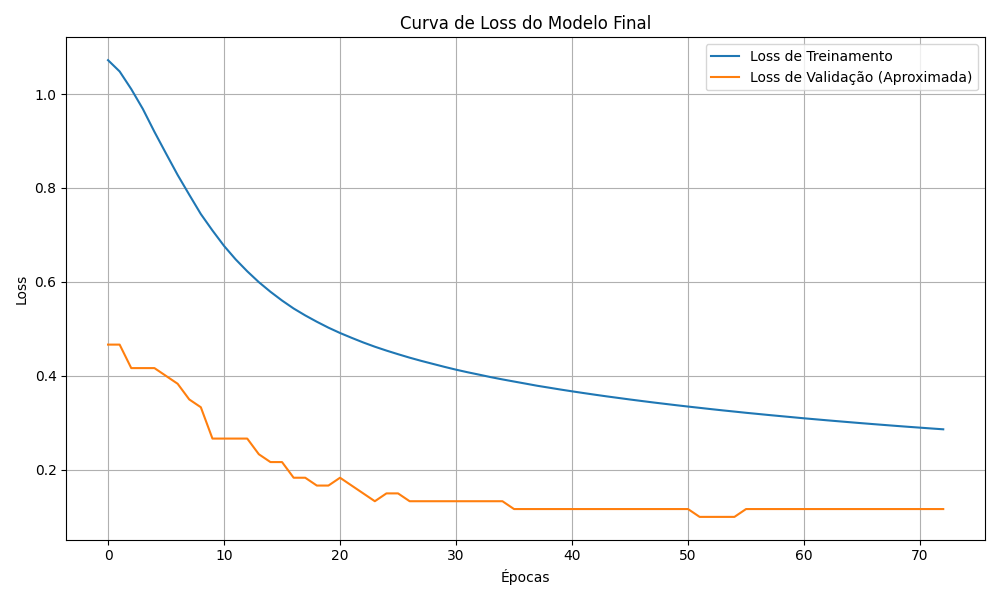

#4. Análise de Resultados
Após a execução do algoritmo genético, o Hall of Fame (hof) armazena o melhor indivíduo encontrado durante todas as gerações. Esse indivíduo representa o conjunto de hiperparâmetros que resultou no maior F1-score obtido no conjunto de validação. Em outras palavras, é a melhor configuração identificada para treinar o modelo de forma eficiente.

##4.1 Melhores Hiperparâmetros
A combinação ótima de hiperparâmetros é exibida no terminal após o fim do processo evolutivo. Esses hiperparâmetros incluem:

* learning_rate_init: taxa de aprendizado inicial usada na atualização dos pesos da rede.

* idden_layer_sizes: quantidade e tamanho das camadas ocultas na MLP (Multilayer Perceptron).

* activation: função de ativação usada nos neurônios (por exemplo, relu, tanh, logistic).

* solver: algoritmo usado para otimização dos pesos (como adam, sgd, entre outros).

* max_iter: número máximo de iterações (épocas) durante o treinamento.

Esses valores foram selecionados automaticamente pelo algoritmo genético com base no desempenho do modelo, medido pelo F1-score no conjunto de validação.

## 4.2 Métricas de Desempenho
Depois de definir os melhores hiperparâmetros, o modelo é re-treinado e, em seguida, avaliado no conjunto de teste, que contém dados nunca vistos durante o treinamento ou validação. Isso permite uma avaliação justa e realista da capacidade do modelo de generalizar para novos dados.

As principais métricas utilizadas para essa avaliação são:

* F1-score: mede o equilíbrio entre precisão e recall.

* Precisão (Precision): indica a proporção de previsões positivas corretas.

* Recall (Revocação): indica a proporção de casos positivos corretamente identificados.

Essas métricas fornecem uma visão abrangente da performance do classificador, especialmente em cenários com classes desbalanceadas.

##4.3 Curvas de Loss
O gráfico apresentado mostra a evolução da função de perda (loss) durante o treinamento, comparando os valores no conjunto de treinamento e no conjunto de validação (aproximada).

* A loss de treinamento tende a diminuir continuamente conforme o modelo se ajusta aos dados.

* A loss de validação idealmente segue um padrão semelhante, indicando que o modelo também está aprendendo a generalizar para novos dados.

Se, porém, a loss de validação começar a aumentar enquanto a loss de treinamento continua diminuindo, isso é um sinal claro de overfitting, ou seja, o modelo está memorizando os dados de treinamento em vez de aprender padrões úteis.

Observação: o MLPClassifier do Scikit-learn fornece a loss de treinamento por meio do atributo loss_curve_. Quando a opção early_stopping=True é usada, os escores de validação são armazenados em validation_scores_. Como esse score geralmente representa acurácia, é possível converter para uma loss aproximada usando loss = 1 - acurácia.

#5. Conclusão
Este notebook demonstrou como algoritmos evolutivos, especificamente um algoritmo genético implementado com a biblioteca DEAP, podem ser utilizados de forma eficaz para otimizar hiperparâmetros de um classificador MLP do scikit-learn.

Essa abordagem se mostra mais inteligente e eficiente do que métodos de busca exaustiva (como grid search), permitindo encontrar configurações que levam a um modelo com melhor desempenho e maior capacidade de generalização.

Além disso, foi destacada a importância de:

* Utilizar métricas robustas, como F1-score, precisão e recall;

* Analisar cuidadosamente as curvas de loss, que ajudam a identificar problemas como overfitting;

* Separar os dados corretamente em treino, validação e teste, para garantir uma avaliação justa e realista do modelo.

Apesar do maior custo computacional envolvido no uso de algoritmos genéticos, sua capacidade de explorar eficientemente espaços de busca complexos os torna uma ferramenta valiosa para projetos de otimização em Machine Learning, especialmente em cenários onde a escolha manual ou busca exaustiva seria inviável.